# UPVOTE! 
# If you like this work please UPVOTE!

After doing a bit of research on neural style transfer, i did not find any working opensource implementaion of Neural Style Tranfer using Keras
- so i dicided to create one Working version of it :)


# References at the bottom <3

# Setting up working directory 

In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input/neural-style/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/neural-style/download.jpeg
/kaggle/input/neural-style/pic.png
/kaggle/input/neural-style/IMG_20200122_074032.jpg
/kaggle/input/neural-style/me.png
/kaggle/input/neural-style/rain.jpg
/kaggle/input/neural-style/1v3.png
/kaggle/input/neural-style/mountain.png
/kaggle/input/neural-style/unnamed.jpg


# Path for input

These are input content and style images. 
We hope to "create" an image with -------- 

the content of our "target_image_path" image,

but with the style of the "style_reference_image_path" image.

In [2]:
from keras.preprocessing.image import load_img, img_to_array

# This is the path to the image you want to transform.
target_image_path = '/kaggle/input/neural-style/IMG_20200122_074032.jpg'
# This is the path to the style image.
style_reference_image_path = '/kaggle/input/neural-style/rain.jpg'

# Dimensions of the generated picture.
width, height = load_img(target_image_path).size
img_height = 400
img_width = int(width * img_height / height)
print(width)
print(height)

Using TensorFlow backend.


1200
900


# Prepare the data

Let's create methods that will allow us to load and preprocess our images easily. We perform the same preprocessing process as are expected according to the VGG training process. 

VGG networks are trained on image with each channel normalized by mean = [103.939, 116.779, 123.68] and with channels BGR. This is also the case for ResNet50.

In [3]:
import numpy as np
from keras.applications import vgg19

def preprocess_image(image_path):
    img = load_img(image_path, target_size=(img_height, img_width))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return img



In order to view the outputs of our optimization, we are required to perform the inverse preprocessing step. Furthermore, since our optimized image may take its values anywhere between $- \infty$ and $\infty$, we must clip to maintain our values from within the 0-255 range.

In [4]:
def deprocess_image(x):
    # Remove zero-center by mean pixel
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x


# The model will be loaded with pre-trained ImageNet weights.

In [5]:
from keras import backend as K

target_image = K.constant(preprocess_image(target_image_path))
style_reference_image = K.constant(preprocess_image(style_reference_image_path))

# This placeholder will contain our generated image
combination_image = K.placeholder((1, img_height, img_width, 3))

# We combine the 3 images into a single batch
input_tensor = K.concatenate([target_image,
                              style_reference_image,
                              combination_image], axis=0)

# We build the VGG19 network with our batch of 3 images as input.
model = vgg19.VGG19(input_tensor=input_tensor,
                    weights='imagenet',
                    include_top=False)

80142336/80134624 [==============================] - 1s 0us/step


In [6]:
model.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

# Important Note
- block5_conv2' is a top level Conv2D layer in our VGG19 model, so we’ll use it to evaluate content. 
- As for style_layers , we’ll use a variety of Conv2D layers ranging from the top to bottom.

# Define and create our loss functions (content and style distances)

**Content Loss**


We will actually add our content losses at each desired layer.

This way, each iteration when we feed our input image through the model (which in eager is simply model(input_image)!) all the content losses through the model will be properly compute and because we are executing eagerly, all the gradients will be computed.

In [7]:
def content_loss(base, combination):
    return K.sum(K.square(combination - base))

# Style loss 
- derived from refrences

In [8]:
def gram_matrix(x):
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    gram = K.dot(features, K.transpose(features))
    return gram


def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_height * img_width
    return K.sum(K.square(S - C)) / (4. * (channels ** 2) * (size ** 2))

In [9]:
def total_variation_loss(x):
    a = K.square(
        x[:, :img_height - 1, :img_width - 1, :] - x[:, 1:, :img_width - 1, :])
    b = K.square(
        x[:, :img_height - 1, :img_width - 1, :] - x[:, :img_height - 1, 1:, :])
    return K.sum(K.pow(a + b, 1.25))

In [10]:
# Dict mapping layer names to activation tensors
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])
# Name of layer used for content loss
content_layer = 'block5_conv2'


# Name of layers used for style loss;
# see "Important Note" cell above
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']
# Weights in the weighted average of the loss components
total_variation_weight = 1e-4
style_weight = 10.
content_weight = 0.025

# Define the loss by adding all components to a `loss` variable
loss = K.variable(0.)
layer_features = outputs_dict[content_layer]
target_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]
loss = loss + content_weight * content_loss(target_image_features,
                                      combination_features)
for layer_name in style_layers:
    layer_features = outputs_dict[layer_name]
    style_reference_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_reference_features, combination_features)
    loss += (style_weight / len(style_layers)) * sl
loss += total_variation_weight * total_variation_loss(combination_image)

In [11]:
# Get the gradients of the generated image wrt the loss
grads = K.gradients(loss, combination_image)[0]

# Function to fetch the values of the current loss and the current gradients
fetch_loss_and_grads = K.function([combination_image], [loss, grads])


class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        x = x.reshape((1, img_height, img_width, 3))
        outs = fetch_loss_and_grads([x])
        loss_value = outs[0]
        grad_values = outs[1].flatten().astype('float64')
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

evaluator = Evaluator()

In [12]:
from keras.preprocessing.image import save_img

# Run scipy-based optimization (L-BFGS) over the pixels of the generated image for gradient descent
- so as to minimize the neural style loss.
- This is our initial state: the target image.
- Note that `scipy.optimize.fmin_l_bfgs_b` can only process flat vectors.

We’ll run 10 iterations, where each iteration consists of 10 steps of gradient descent. We also save the generated image at each iteration so we can track our progress.

In [13]:
from scipy.optimize import fmin_l_bfgs_b
# from scipy.misc import imsave
import time

result_prefix = 'vgg19_try1'
iterations = 10


x = preprocess_image(target_image_path)
x = x.flatten()
for i in range(iterations):
    print('Start of iteration', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x,fprime=evaluator.grads, maxfun=10)
    print('Current loss value:', min_val)
    # Save current generated image
    img = x.copy().reshape((img_height, img_width, 3))
    img = deprocess_image(img)
    fname = result_prefix + '_at_iteration_%d.png' % i
    
    # saving image with the name img
    save_img(fname, img)
    end_time = time.time()
    print('Image saved as', fname)
    print('Iteration %d completed in %ds' % (i, end_time - start_time))

Start of iteration 0
Current loss value: 640231870000.0
Image saved as vgg19_try1_at_iteration_0.png
Iteration 0 completed in 7s
Start of iteration 1
Current loss value: 132402860000.0
Image saved as vgg19_try1_at_iteration_1.png
Iteration 1 completed in 2s
Start of iteration 2
Current loss value: 65107360000.0
Image saved as vgg19_try1_at_iteration_2.png
Iteration 2 completed in 2s
Start of iteration 3
Current loss value: 38707524000.0
Image saved as vgg19_try1_at_iteration_3.png
Iteration 3 completed in 2s
Start of iteration 4
Current loss value: 29450602000.0
Image saved as vgg19_try1_at_iteration_4.png
Iteration 4 completed in 2s
Start of iteration 5
Current loss value: 23147895000.0
Image saved as vgg19_try1_at_iteration_5.png
Iteration 5 completed in 2s
Start of iteration 6
Current loss value: 19092247000.0
Image saved as vgg19_try1_at_iteration_6.png
Iteration 6 completed in 2s
Start of iteration 7
Current loss value: 17167293000.0
Image saved as vgg19_try1_at_iteration_7.png
It

# Visualize outputs

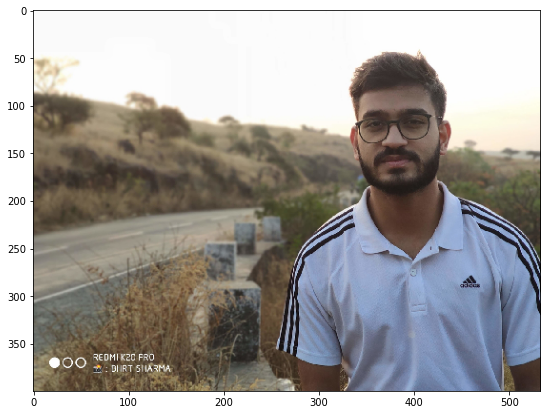

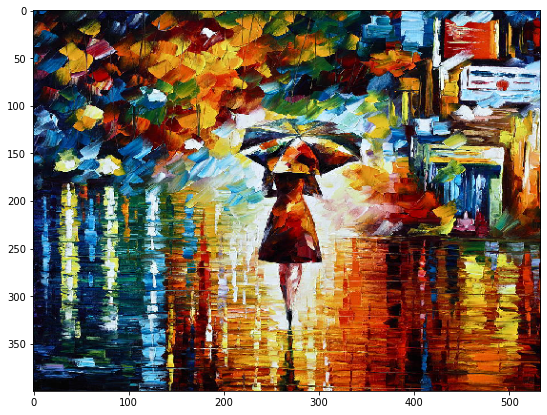

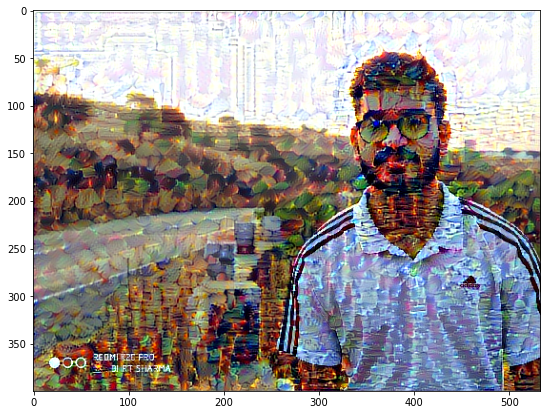

In [14]:
from matplotlib import pyplot as plt

# Content image
plt.figure(figsize=(15,7))
plt.imshow(load_img(target_image_path, target_size=(img_height, img_width)))
plt.figure(figsize=(15,7))
# plt.figure()

# Style image
plt.imshow(load_img(style_reference_image_path, target_size=(img_height, img_width)))
# plt.figure()
plt.figure(figsize=(15,7))

# Generate image
plt.imshow(img)
# plt.show()
# plt.figure(figsize=(20,10))

Here VGG network is used and not ResNET considering following,
- The VGG networks are very big (both are 500MB+ compared to ResNet50’s 99MB) — thus could incidentally capture and store more information than other models.
-  VGG’s are relatively shallow and modular, ResNet’s on the other hand are too spread-out through layers.

# References
- For this work, I leverage

1.Tensorflow implementation of Neural Style Transfer, **but is done using Old version of tesorflow and can't to used with introduction of TensorFlow 2.0**

https://www.kaggle.com/lbarbosa/neural-style-transfer-using-resnet50-with-tf-keras/data#data

2. Medium article by TensorFlow team **which is also outdated** 

https://medium.com/tensorflow/neural-style-transfer-creating-art-with-deep-learning-using-tf-keras-and-eager-execution-7d541ac31398

3. A CVPR paper https://arxiv.org/abs/1508.06576 by Leon A. Gatys, Alexander S. Ecker, Matthias Bethge


******My github link to this notebook :  https://github.com/bhrt-sharma/Neural-Style-Transfer *******